# Import Libraries

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=b72b634da18fc40ebfc241a176b1ff622c8687e76e7c8b83f524d6ee8fe608cc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
# Standard libraries
import math  # Mathematical functions
import os  # Operating system interfaces
import pickle  # Python object serialization
import random  # Generate pseudo-random numbers
import re  # Regular expressions
from collections import defaultdict  # Default dictionary data structure
from datetime import datetime  # Date and time manipulation
from pathlib import Path  # Object-oriented filesystem paths

# Scientific and data processing libraries
import matplotlib.pyplot as plt  # Plotting and visualization
import numpy as np  # Numerical operations on arrays
import pandas as pd  # Data manipulation and analysis

# PyTorch libraries
import torch  # Core PyTorch library
import torchvision  # Computer vision library for PyTorch
from torch import nn  # Neural network components
from torch.nn import CrossEntropyLoss  # Loss function for classification
from torch.optim import AdamW 
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler
from torch.utils.data import DataLoader, Dataset  # Data loading utilities
from torch.utils.tensorboard import SummaryWriter  # TensorBoard writer for logging
from torchmetrics.text import ROUGEScore  # ROUGE score for text evaluation
from torchviz import make_dot

# Image processing
from PIL import Image  # Image processing

# Machine learning utilities
from sklearn.model_selection import train_test_split  # Split arrays or matrices into random train and test subsets

# Transformations for image preprocessing
from torchvision import transforms  # Image transformations
from torchvision.transforms import Normalize, ToPILImage, ToTensor  # Specific image transformations

# Pre-trained models
from torchvision.models import convnext_small  # ConvNeXt small model

# Tokenizer
from transformers import GPT2Tokenizer  # Tokenizer for GPT-2 model

2024-05-23 18:41:09.637614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 18:41:09.637745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 18:41:09.799019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set Constants

In [3]:
# Define the paths to the images and captions
IMAGES_PATH = '/kaggle/input/flickr8k/Images'
CAPTIONS_PATH = '/kaggle/input/flickr8k/captions.txt'

# Define the directory to save the split files
SPLIT_DIR = '/kaggle/working'

# Set Random Seed

In [4]:
# Set a seed value for reproducibility
seed = 42

# Set the random seed for PyTorch
torch.manual_seed(seed)

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed for Python's built-in random module
random.seed(seed)

# If CUDA is available, set the random seed for CUDA as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Set seed for all CUDA devices (if you have multiple GPUs)
    # Ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set environment variables for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

# Function to initialize worker for DataLoader to ensure reproducibility
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)

# Load and Visualize the Data

In [5]:
# Initialize a dictionary to store image captions
captions_dict = {}

# Read the captions file and populate the dictionary
with open(CAPTIONS_PATH, 'r') as f:
    next(f)  # Skip the header line
    for line in f:
        # Split the line into image file and caption
        image_file, caption = line.strip().split(',', 1)
        # If the image file is not already in the dictionary, add it
        if image_file not in captions_dict:
            captions_dict[image_file] = []
        # Append the caption to the list of captions for the image file
        captions_dict[image_file].append(caption)

# List all the image files in the images directory
image_files = [file for file in os.listdir(IMAGES_PATH) if file.endswith('.jpg')]

# Optional: Print the number of images and captions loaded
print(f"Total images: {len(image_files)}")
print(f"Total unique images with captions: {len(captions_dict)}")

Total images: 8091
Total unique images with captions: 8091


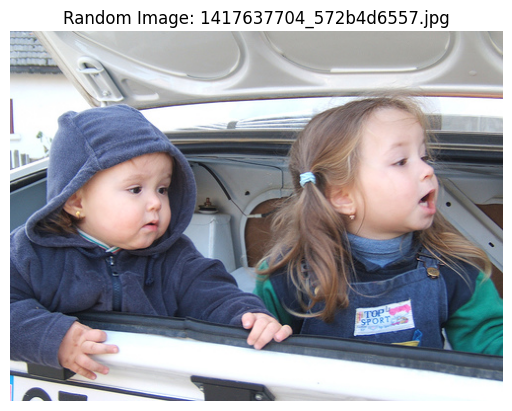

Captions for 1417637704_572b4d6557.jpg:

1. Two children peek out .
2. Two children with brown hair in a trunk of a car .
3. Two small children pop their heads out of the trunk of a car in cold weather .
4. Two small children sitting in the trunk of a car .
5. two young children sitting in the trunk of a car


In [6]:
# Choose a random image file from the list of image files
random_image_file = random.choice(image_files)

# Construct the full path to the chosen image file
random_image_path = os.path.join(IMAGES_PATH, random_image_file)

# Load the image using PIL
image = Image.open(random_image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Random Image: {random_image_file}")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

# Print the captions associated with the selected image, if available
if random_image_file in captions_dict:
    print(f"Captions for {random_image_file}:\n")
    for idx, caption in enumerate(captions_dict[random_image_file], 1):
        print(f"{idx}. {caption}")
else:
    print(f"No captions found for {random_image_file}")

# Create a Transformation Function

In [7]:
class ResizePadTransform:
    def __init__(self, target_size):
        """
        Initialize the transformation with the target size.

        Args:
            target_size (int): The target size for the transformed image.
        """
        self.target_size = target_size

    def __call__(self, image):
        """
        Apply the resize and padding transformation to the given image.

        Args:
            image (PIL.Image.Image): The input image to be transformed.

        Returns:
            PIL.Image.Image: The transformed image with the target size.
        """
        # Calculate the aspect ratio of the original image
        width, height = image.size
        aspect_ratio = width / height

        # Determine the new size after resizing while preserving the aspect ratio
        if width > height:
            new_width = self.target_size
            new_height = int(self.target_size / aspect_ratio)
        else:
            new_height = self.target_size
            new_width = int(self.target_size * aspect_ratio)

        # Resize the image using the calculated new size
        resize_transform = transforms.Resize((new_height, new_width))
        resized_image = resize_transform(image)

        # Calculate the padding required to achieve the target size
        pad_width = self.target_size - new_width
        pad_height = self.target_size - new_height

        # Calculate padding for all sides (left, right, top, bottom)
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Apply the padding transform to the resized image
        padding_transform = transforms.Pad((pad_left, pad_top, pad_right, pad_bottom))
        padded_resized_image = padding_transform(resized_image)

        return padded_resized_image

In [8]:
# Mean and standard deviation values for normalization (ImageNet values)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the image transformation pipeline
tfms = transforms.Compose([
    ResizePadTransform(224),  # Custom transformation to resize and pad the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the tensor using the specified mean and std
])

# Create a Tokenizer

In [9]:
# Initialize the GPT-2 tokenizer from the pre-trained model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add special tokens to the tokenizer
tokenizer.add_special_tokens({
    "bos_token": "<|startoftext|>",  # Beginning of sequence token
    "unk_token": "<|unknown|>",  # Unknown token
    "pad_token": "[PAD]"  # Padding token
})

# Encode a sample text to verify the tokenizer functionality
encoded_text = tokenizer.encode("This is a cat playing.")
print(f"Encoded text: {encoded_text}")

# Decode the encoded text to verify the tokenizer functionality
decoded_text = tokenizer.decode(encoded_text)
print(f"Decoded text: {decoded_text}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Encoded text: [1212, 318, 257, 3797, 2712, 13]
Decoded text: This is a cat playing.


# Transform the Dataset

In [10]:
# Get unique image names directly from captions_dict keys
unique_image_names = list(captions_dict.keys())

# Create train, validation, and test splits (80%, 10%, 10%)
train_val_names, test_names = train_test_split(unique_image_names, test_size=0.1, random_state=42)
train_names, val_names = train_test_split(train_val_names, test_size=0.1 / 0.9, random_state=42)

# Function to save split names to a file
def save_split(file_path, names):
    with open(file_path, 'w') as f:
        for name in names:
            f.write(name + '\n')

# Save the train, validation, and test splits to text files
save_split(os.path.join(SPLIT_DIR, 'train.txt'), train_names)
save_split(os.path.join(SPLIT_DIR, 'val.txt'), val_names)
save_split(os.path.join(SPLIT_DIR, 'test.txt'), test_names)


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, images_path, captions_dict, split_file, transform=None, tokenizer=None, max_len=50, phase="train", count=None):
        """
        Initialize the CustomImageDataset.

        Args:
            images_path (str): Path to the directory containing images.
            captions_dict (dict): Dictionary mapping image filenames to captions.
            split_file (str): Path to the file containing image filenames for the dataset split.
            transform (callable, optional): Optional transform to be applied on an image.
            tokenizer (callable, optional): Tokenizer to be used for encoding captions.
            max_len (int, optional): Maximum length of the tokenized caption.
            phase (str, optional): Phase of the dataset (train, eval, or test).
            count (int, optional): Optional count to limit the number of images.
        """
        self.images_path = images_path
        self.captions_dict = captions_dict

        # Load image names from the split file
        split_file = Path(split_file)
        self.image_names = pd.read_csv(split_file, header=None)[0]

        # Limit the number of images if count is specified
        if count is not None:
            self.image_names = self.image_names.iloc[:count]

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.phase = phase

    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Retrieve an image and its corresponding caption.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image, its caption, and the image name.
        """
        # Get the image name and path
        image_name = self.image_names.iloc[idx]
        image_path = os.path.join(self.images_path, image_name)
        
        # Load and transform the image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Get the caption for the image
        caption = random.choice(self.captions_dict[image_name])
        caption = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"
        caption = self.tokenizer.encode(caption)
        
        # Pad the caption to the maximum length
        pad_tokens = self.max_len - len(caption) + 1
        caption += pad_tokens * [self.tokenizer.pad_token_id]
        caption = torch.tensor(caption)

        # Decode the caption if the phase is not "train" or "eval"
        if self.phase not in ["train", "eval"]:
            caption = self.tokenizer.decode(caption, skip_special_tokens=True)

        return {"image": image, "caption": caption, "image_name": image_name}

# Create Train, Val, Test Datasets

In [12]:
# Initialize the train, eval, and test datasets
train_dataset = CustomImageDataset(
    images_path=IMAGES_PATH, 
    captions_dict=captions_dict, 
    split_file=os.path.join(SPLIT_DIR, 'train.txt'), 
    transform=tfms, 
    tokenizer=tokenizer, 
    phase='train'
)

eval_dataset = CustomImageDataset(
    images_path=IMAGES_PATH, 
    captions_dict=captions_dict, 
    split_file=os.path.join(SPLIT_DIR, 'val.txt'), 
    transform=tfms, 
    tokenizer=tokenizer, 
    phase='eval'
)

test_dataset = CustomImageDataset(
    images_path=IMAGES_PATH, 
    captions_dict=captions_dict, 
    split_file=os.path.join(SPLIT_DIR, 'test.txt'), 
    transform=tfms, 
    tokenizer=tokenizer, 
    phase='test'
)

# Print the number of samples in each dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(eval_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 6472
Validation dataset size: 809
Test dataset size: 810


# Create HPO Train, Val Datasets

In [13]:
# Initialize the train and eval datasets with a limited number of samples for hyperparameter optimization
hpo_train_dataset = CustomImageDataset(
    images_path=IMAGES_PATH, 
    captions_dict=captions_dict, 
    split_file=os.path.join(SPLIT_DIR, 'train.txt'), 
    transform=tfms, 
    tokenizer=tokenizer, 
    phase='train', 
    count=250  # Limit the number of samples for hyperparameter optimization
)

hpo_eval_dataset = CustomImageDataset(
    images_path=IMAGES_PATH, 
    captions_dict=captions_dict, 
    split_file=os.path.join(SPLIT_DIR, 'val.txt'), 
    transform=tfms, 
    tokenizer=tokenizer, 
    phase='eval', 
    count=250  # Limit the number of samples for hyperparameter optimization
)

# Print the number of samples in the limited datasets
print(f"Hyperparameter optimization train dataset size: {len(hpo_train_dataset)}")
print(f"Hyperparameter optimization validation dataset size: {len(hpo_eval_dataset)}")

Hyperparameter optimization train dataset size: 250
Hyperparameter optimization validation dataset size: 250


# Train Example

In [14]:
def print_random_sample(dataset, dataset_name):
    """
    Print a random sample from the specified dataset.

    Args:
        dataset (Dataset): The dataset to sample from.
        dataset_name (str): The name of the dataset (for printing purposes).
    """
    # Generate a random index within the range of the dataset length
    idx = random.randint(0, len(dataset) - 1)
    
    # Retrieve the sample at the generated index
    sample = dataset[idx]
    
    # Print the details of the sample
    print(f"Random sample from {dataset_name} dataset:\n")
    print("Image tensor:", sample["image"])
    print("Captions:", sample["caption"])
    print("Image name:", sample["image_name"])

# Print a random sample from the train dataset
print_random_sample(train_dataset, "train")

Random sample from train dataset:

Image tensor: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.804

# Test Example

In [15]:
# Print a random sample from the test dataset
print_random_sample(test_dataset, "test")

Random sample from test dataset:

Image tensor: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044

# Create a DataLoader

In [16]:
# Define the batch size for the dataloaders
BATCH_SIZE = 8

# Initialize the DataLoader for the training dataset with shuffling
train_dataloader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)


# Initialize the DataLoader for the evaluation dataset without shuffling
eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

# Initialize the DataLoader for the test dataset without shuffling
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

# Print the number of batches in each dataloader
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in eval_dataloader: {len(eval_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")

Number of batches in train_dataloader: 809
Number of batches in eval_dataloader: 102
Number of batches in test_dataloader: 102


In [17]:
# Initialize the DataLoader for the hyperparameter optimization (HPO) training dataset with shuffling
hpo_train_dataloader = DataLoader(
    hpo_train_dataset, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

# Initialize the DataLoader for the hyperparameter optimization (HPO) evaluation dataset without shuffling
hpo_eval_dataloader = DataLoader(
    hpo_eval_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

# Print the number of batches in the hyperparameter optimization (HPO) dataloaders
print(f"Number of batches in hpo_train_dataloader: {len(hpo_train_dataloader)}")
print(f"Number of batches in hpo_eval_dataloader: {len(hpo_eval_dataloader)}")

Number of batches in hpo_train_dataloader: 32
Number of batches in hpo_eval_dataloader: 32


# Prepare ConvNeXt Model

In [18]:
def get_cnn_model():
    """
    Create and modify a ConvNeXt small model by removing the last two layers.

    Returns:
        nn.Sequential: The modified ConvNeXt small model.
    """
    # Load the ConvNeXt small model with pre-trained weights
    model = convnext_small(weights=torchvision.models.convnext.ConvNeXt_Small_Weights.IMAGENET1K_V1)
    
    # Modify the model by removing the last two layers
    model = nn.Sequential(*list(model.children())[:-2])
    
    return model

# Instantiate the modified ConvNeXt small model
model = get_cnn_model()

# Test the model with a random input tensor of shape (8, 3, 224, 224)
input_tensor = torch.rand(8, 3, 224, 224)
output_tensor = model(input_tensor)

# Print the shape of the output tensor
print(f"Output tensor shape: {output_tensor.shape}")

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 168MB/s]


Output tensor shape: torch.Size([8, 768, 7, 7])


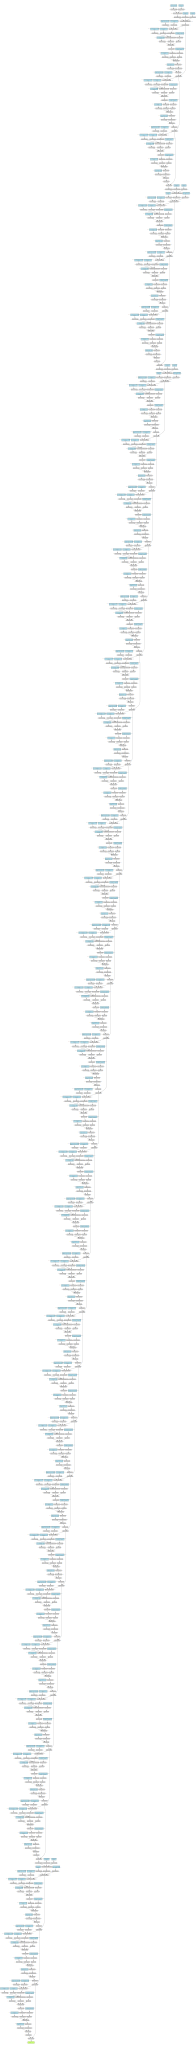

In [19]:
make_dot(output_tensor, params=dict(list(model.named_parameters())))

# Create a Model using ConvNeXt and Transformer Decoder

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Initialize the PositionalEncoding module.

        Args:
            d_model (int): The dimension of the model.
            dropout (float): The dropout rate to apply after adding positional encoding.
            max_len (int): The maximum length of the input sequences.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of shape (max_len, 1) representing positions
        position = torch.arange(max_len).unsqueeze(1)

        # Compute the division term for the positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # Initialize the positional encoding matrix with zeros
        pe = torch.zeros(max_len, 1, d_model)

        # Apply sinusoidal functions to compute positional encodings
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        # Register the positional encoding matrix as a buffer (not a parameter)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for adding positional encoding to the input tensor.

        Args:
            x (Tensor): Input tensor of shape [seq_len, batch_size, embedding_dim].

        Returns:
            Tensor: Output tensor with positional encoding added.
        """
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(0)]

        # Apply dropout and return the result
        return self.dropout(x)

In [21]:
class TransformerDecoder(nn.Module):
    def __init__(self, emb_size, nhead, num_decoder_layers, tgt_vocab_size, dim_feedforward, dropout, activation):
        """
        Initialize the TransformerDecoder module.

        Args:
            emb_size (int): Embedding size.
            nhead (int): Number of attention heads.
            num_decoder_layers (int): Number of decoder layers.
            tgt_vocab_size (int): Target vocabulary size.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
            activation (str): Activation function.
        """
        super(TransformerDecoder, self).__init__()
        self.emb_size = emb_size

        self.embedding = nn.Embedding(tgt_vocab_size, emb_size)
        self.text_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=emb_size,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation=activation,
            ),
            num_layers=num_decoder_layers
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        """
        Initialize the weights of the embedding and generator layers.
        """
        range = 0.1
        self.embedding.weight.data.uniform_(-range, range)
        self.generator.bias.data.zero_()
        self.generator.weight.data.uniform_(-range, range)

    def forward(self, src_emb, tgt_tokens, tgt_mask, tgt_padding_mask):
        """
        Forward pass for the TransformerDecoder.

        Args:
            src_emb (Tensor): Source embeddings of shape [batch_size, embed_dim, height, width].
            tgt_tokens (Tensor): Target tokens.
            tgt_mask (Tensor): Target mask.
            tgt_padding_mask (Tensor): Target padding mask.

        Returns:
            Tensor: Output logits.
        """
        B, D, H, W = src_emb.shape
        src_emb = src_emb.reshape(B, D, -1).permute(2, 0, 1)  # Reshape and permute for Transformer input
        src_emb = self.positional_encoding(src_emb)  # Add positional encoding to source embeddings

        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)  # Embed target tokens and scale
        tgt_emb = tgt_emb.permute(1, 0, 2)  # Permute for Transformer input
        tgt_emb = self.positional_encoding(tgt_emb)  # Add positional encoding to target embeddings

        outs = self.text_decoder(tgt_emb, src_emb, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)  # Decode

        return self.generator(outs)  # Generate logits

    def generate(self, img_ft, tgt_tokens):
        """
        Generate predictions given image features and target tokens.

        Args:
            img_ft (Tensor): Image features.
            tgt_tokens (Tensor): Target tokens.

        Returns:
            Tensor: Generated logits.
        """
        src_emb = self.positional_encoding(img_ft)  # Add positional encoding to image features
        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)  # Embed target tokens and scale
        tgt_emb = tgt_emb.permute(1, 0, 2)  # Permute for Transformer input
        tgt_emb = self.positional_encoding(tgt_emb)  # Add positional encoding to target embeddings

        outs = self.text_decoder(tgt_emb, src_emb)  # Decode

        return self.generator(outs)  # Generate logits

class CaptionModel(nn.Module):
    def __init__(self, emb_size, nhead, num_decoder_layers, tgt_vocab_size, dim_feedforward, dropout, activation):
        """
        Initialize the CaptionModel.

        Args:
            emb_size (int): Embedding size.
            nhead (int): Number of attention heads.
            num_decoder_layers (int): Number of decoder layers.
            tgt_vocab_size (int): Target vocabulary size.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
            activation (str): Activation function.
        """
        super(CaptionModel, self).__init__()
        self.image_encoder = get_cnn_model()  # Initialize the image encoder
        self.text_decoder = TransformerDecoder(
            emb_size,
            nhead,
            num_decoder_layers,
            tgt_vocab_size,
            dim_feedforward,
            dropout,
            activation
        )  # Initialize the text decoder

    def forward(self, img_op, tgt_tokens, tgt_mask, tgt_padding_mask):
        """
        Forward pass for the CaptionModel.

        Args:
            img_op (Tensor): Image output from the encoder.
            tgt_tokens (Tensor): Target tokens.
            tgt_mask (Tensor): Target mask.
            tgt_padding_mask (Tensor): Target padding mask.

        Returns:
            Tensor: Output logits from the text decoder.
        """
        src_emb = self.image_encoder(img_op)  # Encode the image
        text_op = self.text_decoder(src_emb, tgt_tokens, tgt_mask, tgt_padding_mask)  # Decode the text

        return text_op

# Set the Loss function

In [22]:
# Initialize the CrossEntropyLoss criterion
# This criterion computes the cross-entropy loss between the predicted and true class probabilities
# `ignore_index` specifies a target value that is ignored and does not contribute to the input gradient
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Set the Optimizer Constants

In [23]:
# Define the number of epochs for the optimizer
NUM_EPOCHS_FOR_OPTIMIZER = 10

# Define learning rates for the transformer and CNN components
TRANSFORMER_LEARNING_RATE = 1e-4
CNN_LEARNING_RATE = 1e-5

# Create Mask

In [24]:
def create_mask(src, tgt, pad_idx):
    """
    Generate masks for the target sequence to ignore future tokens and padding tokens.

    Args:
        src (Tensor): Source sequence tensor (not used in this function but typically required for compatibility).
        tgt (Tensor): Target sequence tensor.
        pad_idx (int): Padding token index.

    Returns:
        Tuple[Tensor, Tensor]: Tuple containing the target mask and target padding mask.
    """
    tgt_seq_len = tgt.shape[1]

    # Generate the target mask to ignore future tokens
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # Generate the target padding mask to ignore padding tokens
    tgt_padding_mask = (tgt == pad_idx)
    
    return tgt_mask, tgt_padding_mask

def generate_square_subsequent_mask(sz, device="cpu"):
    """
    Generate a square subsequent mask for a sequence to prevent attending to future tokens.

    Args:
        sz (int): Size of the mask (sequence length).
        device (str, optional): Device to create the mask on (default is "cpu").

    Returns:
        Tensor: The subsequent mask for the sequence.
    """
    # Create a mask with ones in the upper triangle and zeros elsewhere
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    
    # Convert the mask to float and replace zeros with -inf and ones with 0.0
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    return mask

# Create Train Configuration

In [25]:
def train(model, num_epochs, exp_dir, train_losses, val_losses, checkpoint_epoch, train_dataloader, eval_dataloader, num_layer, dropout, save_model=False):
    """
    Train the model and save the training progress.

    Args:
        model (nn.Module): The model to train.
        num_epochs (int): Number of epochs to train.
        exp_dir (str): Directory to save the experiment logs and model checkpoints.
        train_losses (list): List to store training losses.
        val_losses (list): List to store validation losses.
        checkpoint_epoch (int): Interval for saving model checkpoints.
        train_dataloader (DataLoader): DataLoader for the training data.
        eval_dataloader (DataLoader): DataLoader for the evaluation data.
        num_layer (int): Number of layers in the model.
        dropout (float): Dropout rate.

    Returns:
        None
    """
    writer = SummaryWriter(exp_dir)  # Initialize TensorBoard writer

    for e in range(num_epochs):
        print(f"{e + 1}. epoch started to run at {datetime.now().strftime('%H:%M:%S')}")
        model.train()
        train_running_loss = 0.0
        i = 0

        # Training loop
        for idx, data in enumerate(train_dataloader):
            imgs = data["image"].to(DEVICE)
            target = data["caption"].to(DEVICE)

            target_in = target[:, :-1]
            target_out = target[:, 1:]

            model.zero_grad(set_to_none=True)
            tgt_mask, tgt_padding_mask = create_mask(imgs, target_in, pad_idx=tokenizer.pad_token_id)

            # Ensure tgt_mask and tgt_padding_mask are of the same type
            if tgt_mask.dtype != tgt_padding_mask.dtype:
                tgt_padding_mask = tgt_padding_mask.to(tgt_mask.dtype)

            logits = model(imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE))
            T, B, D = logits.shape

            loss = criterion(logits.permute(1, 0, 2).reshape(T * B, D), target_out.reshape(T * B))
            writer.add_scalar("loss/train", loss.item(), (e * len(train_dataloader) + idx))

            loss.backward()
            optimizer_cnn.step()
            optimizer_transformer.step()

            train_running_loss += loss.item()
            i += 1

        scheduler_cnn.step()
        scheduler_transformer.step()

        train_epoch_loss = train_running_loss / i
        train_losses.append(train_epoch_loss)
        writer.add_scalar("epoch_loss/train", train_epoch_loss, e)

        # Evaluation loop
        if (e + 1) % checkpoint_epoch == 0:
            model.eval()
            eval_running_loss = 0.0
            i = 0

            with torch.no_grad():
                for idx, data in enumerate(eval_dataloader):
                    imgs = data["image"].to(DEVICE)
                    target = data["caption"].to(DEVICE)

                    target_in = target[:, :-1]
                    target_out = target[:, 1:]

                    tgt_mask, tgt_padding_mask = create_mask(imgs, target_in, pad_idx=tokenizer.pad_token_id)

                    # Ensure tgt_mask and tgt_padding_mask are of the same type
                    if tgt_mask.dtype != tgt_padding_mask.dtype:
                        tgt_padding_mask = tgt_padding_mask.to(tgt_mask.dtype)

                    logits = model(imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE))
                    T, B, D = logits.shape

                    loss = criterion(logits.permute(1, 0, 2).reshape(T * B, D), target_out.reshape(T * B))
                    eval_running_loss += loss.item()
                    i += 1

                eval_epoch_loss = eval_running_loss / i
                val_losses.append(eval_epoch_loss)
                writer.add_scalar("epoch_loss/eval", eval_epoch_loss, e)
                
                print(f"\ntrain loss after epoch {e + 1}: {train_epoch_loss}")
                print(f"eval loss after epoch {e + 1}: {eval_epoch_loss} \n")

 
            if save_model:
                # Save the model checkpoint
                torch.save(model.state_dict(), f"{exp_dir}/model_epoch_{e+1}_dropout_{dropout}_layers_{num_layer}.pt")

    if val_losses:
        print(f"\nBest validation loss was {min(val_losses)} in {(val_losses.index(min(val_losses))+1) * checkpoint_epoch}. epoch")
    
    # Plotting the training and validation loss
    plt.figure(figsize=(6, 3))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(checkpoint_epoch, len(train_losses)+1, checkpoint_epoch), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    print("\n")

# Hyper Parameter Optimization

Results for the model with 5 layers and 0.3 dropout
--------------------------------------------------
1. epoch started to run at 18:41:33

train loss after epoch 1: 7.366190478205681
eval loss after epoch 1: 6.174012899398804 

2. epoch started to run at 18:41:49

train loss after epoch 2: 5.757007420063019
eval loss after epoch 2: 5.395866617560387 


Best validation loss was 5.395866617560387 in 2. epoch


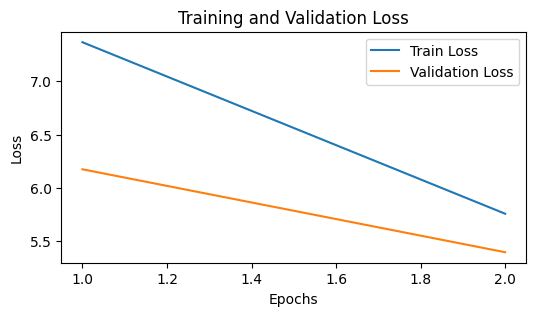



Results for the model with 5 layers and 0.4 dropout
--------------------------------------------------
1. epoch started to run at 18:42:06

train loss after epoch 1: 7.9953433573246
eval loss after epoch 1: 6.2375742346048355 

2. epoch started to run at 18:42:20

train loss after epoch 2: 6.079656600952148
eval loss after epoch 2: 5.4849183559417725 


Best validation loss was 5.4849183559417725 in 2. epoch


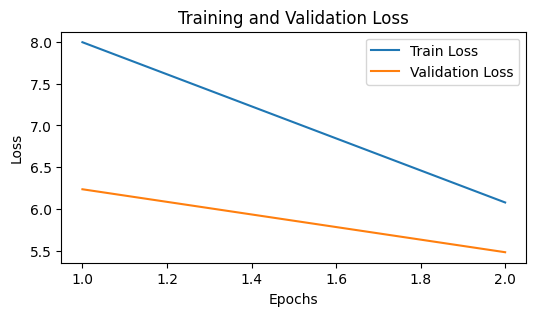



Results for the model with 5 layers and 0.5 dropout
--------------------------------------------------
1. epoch started to run at 18:42:37

train loss after epoch 1: 8.240017533302307
eval loss after epoch 1: 6.569879189133644 

2. epoch started to run at 18:42:51

train loss after epoch 2: 6.318832844495773
eval loss after epoch 2: 5.7427418529987335 


Best validation loss was 5.7427418529987335 in 2. epoch


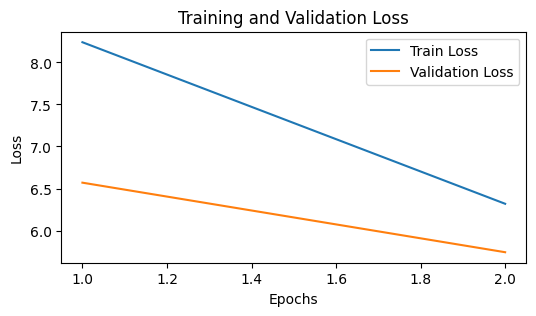



Results for the model with 6 layers and 0.3 dropout
--------------------------------------------------
1. epoch started to run at 18:43:08

train loss after epoch 1: 7.661859855055809
eval loss after epoch 1: 6.116361126303673 

2. epoch started to run at 18:43:23

train loss after epoch 2: 5.835534334182739
eval loss after epoch 2: 5.30788853764534 


Best validation loss was 5.30788853764534 in 2. epoch


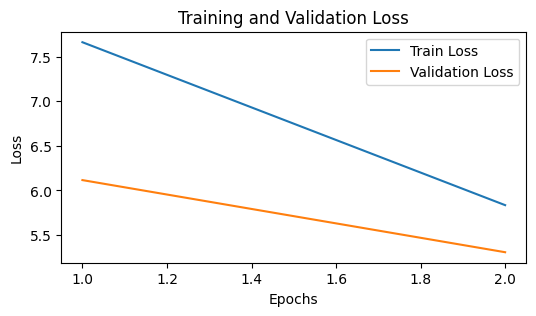



Results for the model with 6 layers and 0.4 dropout
--------------------------------------------------
1. epoch started to run at 18:43:41

train loss after epoch 1: 8.00385881960392
eval loss after epoch 1: 6.5535513162612915 

2. epoch started to run at 18:43:56

train loss after epoch 2: 6.01705464720726
eval loss after epoch 2: 5.520387351512909 


Best validation loss was 5.520387351512909 in 2. epoch


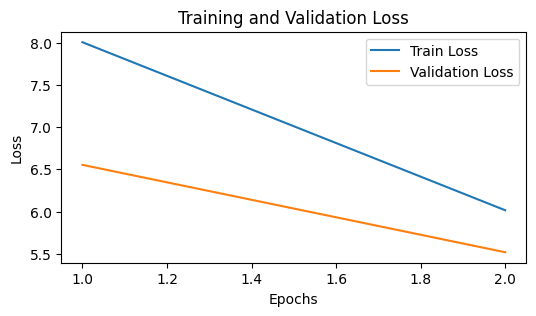



Results for the model with 6 layers and 0.5 dropout
--------------------------------------------------
1. epoch started to run at 18:44:14

train loss after epoch 1: 8.260368689894676
eval loss after epoch 1: 6.788080960512161 

2. epoch started to run at 18:44:29

train loss after epoch 2: 6.573228791356087
eval loss after epoch 2: 5.824365481734276 


Best validation loss was 5.824365481734276 in 2. epoch


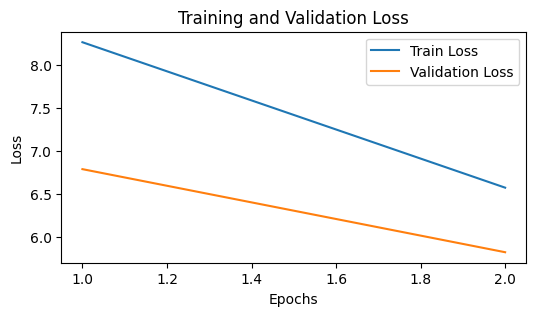



Results for the model with 7 layers and 0.3 dropout
--------------------------------------------------
1. epoch started to run at 18:44:47

train loss after epoch 1: 7.651039361953735
eval loss after epoch 1: 6.1887819319963455 

2. epoch started to run at 18:45:03

train loss after epoch 2: 5.997203558683395
eval loss after epoch 2: 5.382658630609512 


Best validation loss was 5.382658630609512 in 2. epoch


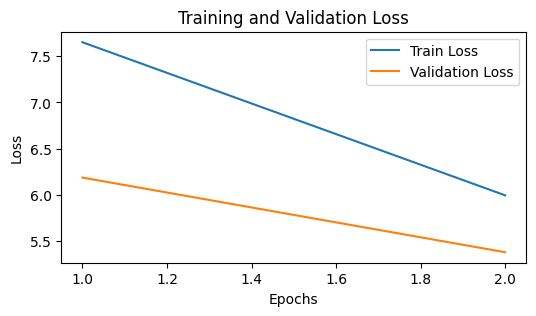



Results for the model with 7 layers and 0.4 dropout
--------------------------------------------------
1. epoch started to run at 18:45:21

train loss after epoch 1: 8.095285415649414
eval loss after epoch 1: 6.57073700428009 

2. epoch started to run at 18:45:37

train loss after epoch 2: 6.155220702290535
eval loss after epoch 2: 5.548039361834526 


Best validation loss was 5.548039361834526 in 2. epoch


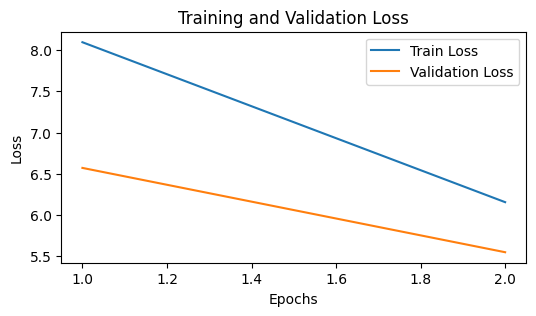



Results for the model with 7 layers and 0.5 dropout
--------------------------------------------------
1. epoch started to run at 18:45:55

train loss after epoch 1: 8.221087098121643
eval loss after epoch 1: 7.037013575434685 

2. epoch started to run at 18:46:11

train loss after epoch 2: 6.7963771522045135
eval loss after epoch 2: 5.997751325368881 


Best validation loss was 5.997751325368881 in 2. epoch


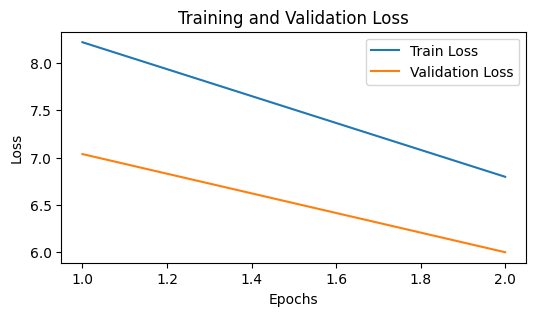

In [26]:
# Define the number of layers and dropout rates to experiment with
num_layers = [5, 6, 7]
dropouts = [0.3, 0.4, 0.5]

# Iterate over each combination of number of layers and dropout rates
for num_layer in num_layers:
    for dropout in dropouts:
        # Define model hyperparameters
        EMB_DIM = 768
        NHEAD = 8
        DIM_FEEDFORWARD = 2048
        ACTIVATION = "gelu"

        # Initialize the CaptionModel with the current hyperparameters
        model = CaptionModel(
            emb_size=EMB_DIM,
            nhead=NHEAD,
            num_decoder_layers=num_layer,
            tgt_vocab_size=len(tokenizer),
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=dropout,
            activation=ACTIVATION,
        )

        # Initialize the optimizer for the CNN component of the model
        optimizer_cnn = AdamW(
            model.image_encoder.parameters(),  # Parameters of the image encoder (CNN)
            lr=TRANSFORMER_LEARNING_RATE  # Learning rate for the CNN optimizer
        )

        # Initialize the optimizer for the Transformer component of the model
        optimizer_transformer = AdamW(
            model.text_decoder.parameters(),  # Parameters of the text decoder (Transformer)
            lr=TRANSFORMER_LEARNING_RATE  # Learning rate for the Transformer optimizer
        )

        # Initialize the learning rate scheduler for the CNN optimizer
        scheduler_cnn = CosineAnnealingLR(
            optimizer_cnn,  # Optimizer for the CNN
            T_max=NUM_EPOCHS_FOR_OPTIMIZER  # Maximum number of epochs
        )

        # Initialize the learning rate scheduler for the Transformer optimizer
        scheduler_transformer = CosineAnnealingLR(
            optimizer_transformer,  # Optimizer for the Transformer
            T_max=NUM_EPOCHS_FOR_OPTIMIZER  # Maximum number of epochs
        )

        # Define experiment parameters
        exp_dir = "cap_gen_exp/hpo"
        num_epochs = 2
        checkpoint_epoch = 1
        train_losses = []
        val_losses = []

        # Determine the device to run the training on (GPU if available, otherwise CPU)
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(DEVICE)

        # Print the current experiment configuration
        print(f"Results for the model with {num_layer} layers and {dropout} dropout")
        print("-" * 50)
        
        train(model, num_epochs, exp_dir, train_losses, val_losses, checkpoint_epoch, hpo_train_dataloader, hpo_eval_dataloader, num_layer, dropout)

# Create the Model with Best Configuration

In [27]:
# Define model hyperparameters
NUM_LAYER = 7
DROPOUT = 0.3
EMB_DIM = 768
NHEAD = 8
DIM_FEEDFORWARD = 2048
ACTIVATION = "gelu"

# Initialize the CaptionModel with the current hyperparameters
model = CaptionModel(
    emb_size=EMB_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_LAYER,
    tgt_vocab_size=len(tokenizer),
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    activation=ACTIVATION,
)

# Initialize the optimizer for the CNN component of the model
optimizer_cnn = AdamW(
    model.image_encoder.parameters(),  # Parameters of the image encoder (CNN)
    lr=TRANSFORMER_LEARNING_RATE  # Learning rate for the CNN optimizer
)

# Initialize the optimizer for the Transformer component of the model
optimizer_transformer = AdamW(
    model.text_decoder.parameters(),  # Parameters of the text decoder (Transformer)
    lr=TRANSFORMER_LEARNING_RATE  # Learning rate for the Transformer optimizer
)

# Initialize the learning rate scheduler for the CNN optimizer
scheduler_cnn = CosineAnnealingLR(
    optimizer_cnn,  # Optimizer for the CNN
    T_max=NUM_EPOCHS_FOR_OPTIMIZER  # Maximum number of epochs
)

# Initialize the learning rate scheduler for the Transformer optimizer
scheduler_transformer = CosineAnnealingLR(
    optimizer_transformer,  # Optimizer for the Transformer
    T_max=NUM_EPOCHS_FOR_OPTIMIZER  # Maximum number of epochs
)

# Define experiment parameters
exp_dir = "cap_gen_exp"
num_epochs = 2
checkpoint_epoch = 1
train_losses = []
val_losses = []

# Determine the device to run the training on (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

# Train the Model with Best Configuration

1. epoch started to run at 18:46:30

train loss after epoch 1: 4.5472571534485695
eval loss after epoch 1: 3.729591048231312 

2. epoch started to run at 18:51:49

train loss after epoch 2: 3.631632475387328
eval loss after epoch 2: 3.3187252949265873 


Best validation loss was 3.3187252949265873 in 2. epoch


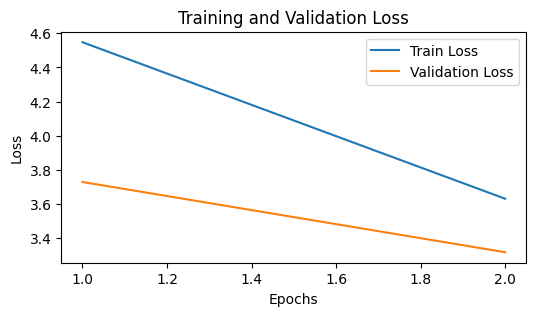

In [28]:
train(model, num_epochs, exp_dir, train_losses, val_losses, checkpoint_epoch, train_dataloader, eval_dataloader, NUM_LAYER, DROPOUT, save_model=True)

# Load the Model with Best Epoch Number

In [29]:
PATH = "/kaggle/working/cap_gen_exp/model_epoch_2_dropout_0.3_layers_7.pt"

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Evaluate the Model

In [30]:
def eval_collate(batch_data):
    """
    Collate function for evaluation dataloader.

    Args:
        batch_data (list): List of dictionaries containing image, caption, and image name.

    Returns:
        dict: Dictionary containing a single batch with image, caption, and image name.
    """
    # Extract data from the first item in the batch_data
    images = batch_data[0]["image"].unsqueeze(0)
    caption = batch_data[0]["caption"]
    image_name = batch_data[0]["image_name"]

    # Create a dictionary to store the batch data
    data = {"image": images, "caption": caption, "image_name": image_name}

    return data

# Initialize the test dataloader with the custom collate function
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=eval_collate)

# Initialize a dictionary to store prediction results
pred_results = defaultdict(list)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        imgs = data["image"].to(DEVICE)
        references = data["caption"]
        image_name = data["image_name"]

        # Process the image features
        img_ftr = model.image_encoder(imgs).reshape(1, EMB_DIM, -1).permute(2, 0, 1)

        # Initialize the list of predicted tokens with the BOS token
        pred_tokens = [tokenizer.bos_token_id]

        # Generate predictions until the EOS token is reached or max length is exceeded
        while (pred_tokens[-1] != tokenizer.eos_token_id if len(pred_tokens) > 1 else True) and len(pred_tokens) <= 50:
            cur_tokens = torch.tensor(pred_tokens).unsqueeze(0).to(DEVICE)
            pred = model.text_decoder.generate(img_ftr, cur_tokens)[-1]

            pred_tokens.append(pred.detach().cpu().argmax(-1).item())

        # Decode the predicted tokens to obtain the predicted caption
        pred_caption = tokenizer.decode(pred_tokens)

        # Store the results in the prediction dictionary
        pred_results["image_name"].append(image_name)
        pred_results["prediction"].append(pred_caption)
        pred_results["references"].append(references)

# Prepare predictions and references for evaluation
predictions = [x.replace("<|startoftext|>", "").replace("<|endoftext|>", "") for x in pred_results["prediction"]]

# Calculate the ROUGE-L score
rouge_score = ROUGEScore()
rouge_score_value = rouge_score(predictions, references)["rougeL_fmeasure"]

# Print the ROUGE-L score
print(f"ROUGE-L F1 Score: {rouge_score_value}")

ROUGE-L F1 Score: 0.3333333432674408


# MAKE PREDICTIONS

Target Image and Caption


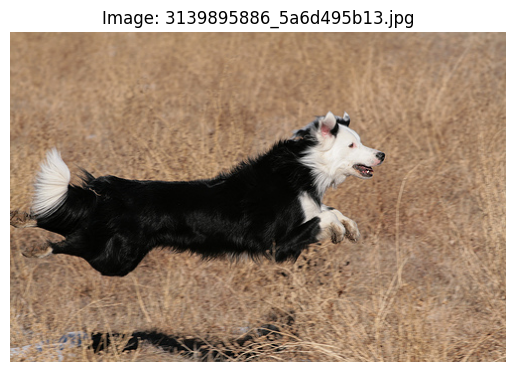

Captions for 3139895886_5a6d495b13.jpg:
  a dog runs through the dry grass. 

 Predicted caption for 3139895886_5a6d495b13.jpg:
  A dog running in a field.  


Target Image and Caption


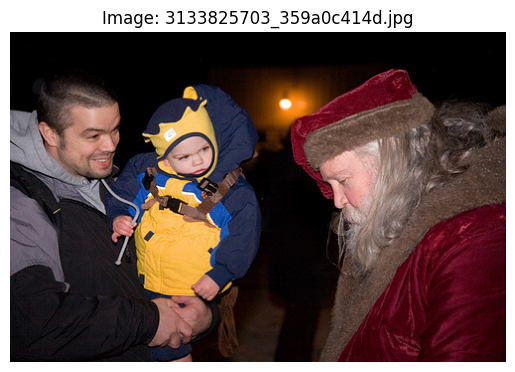

Captions for 3133825703_359a0c414d.jpg:
  The child is looking at Santa Claus. 

 Predicted caption for 3133825703_359a0c414d.jpg:
  A man in a red shirt and a red hat and a red hat.  


Target Image and Caption


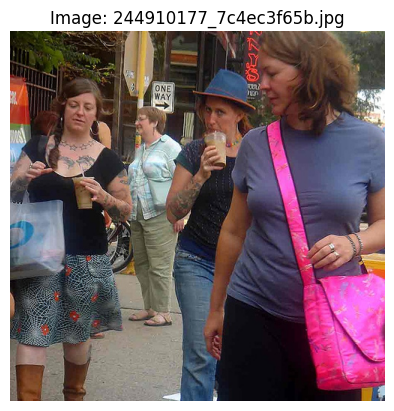

Captions for 244910177_7c4ec3f65b.jpg:
  Three woman walk down a city street and one has a pink purse. 

 Predicted caption for 244910177_7c4ec3f65b.jpg:
  A man in a black shirt and a black shirt and a black hat and a black hat.  


Target Image and Caption


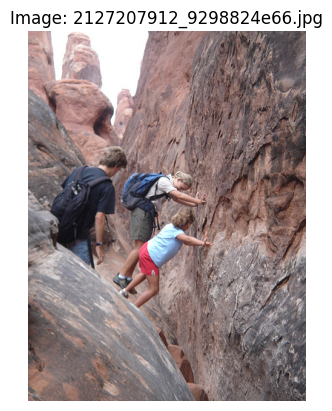

Captions for 2127207912_9298824e66.jpg:
  Two people wearing backpacks and a woman in red shorts are standing on some large rock formations. 

 Predicted caption for 2127207912_9298824e66.jpg:
  A man climbing a rock rock rock rock rock climbing.  


Target Image and Caption


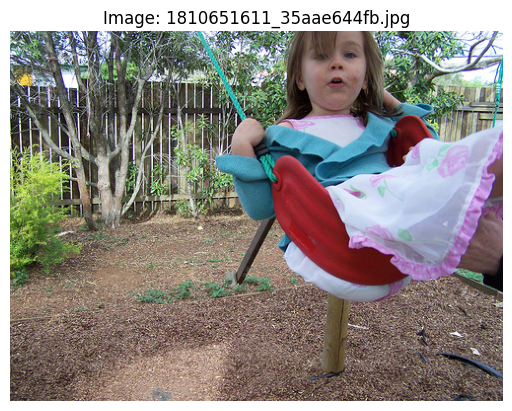

Captions for 1810651611_35aae644fb.jpg:
  A closeup of a little girl on a swing. 

 Predicted caption for 1810651611_35aae644fb.jpg:
  A girl is sitting on a swing.  




In [31]:
# Define the number of examples to display
EXAMPLE_SIZE = 5

# Disable gradient calculation for evaluation
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        imgs = data["image"].to(DEVICE)
        captions = data["caption"]
        image_name = data["image_name"]
        
        # Print target image and caption information
        print("Target Image and Caption")
        
        # Construct the full path to the image file
        image_path = os.path.join(IMAGES_PATH, image_name)
        
        # Load and display the image
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(f"Image: {image_name}")
        plt.axis('off')  # Hide the axis
        plt.show()
        
        # Print the captions for the selected image
        print(f"Captions for {image_name}:\n {captions}")
        
        # Process the image features through the model's image encoder
        img_ftr = model.image_encoder(imgs).reshape(1, EMB_DIM, -1).permute(2, 0, 1)
        
        # Initialize the list of predicted tokens with the BOS token
        pred_tokens = [tokenizer.bos_token_id]
        
        # Generate predictions until the EOS token is reached or max length is exceeded
        while (pred_tokens[-1] != tokenizer.eos_token_id if len(pred_tokens) > 1 else True) and len(pred_tokens) <= 50:
            cur_tokens = torch.tensor(pred_tokens).unsqueeze(0).to(DEVICE)
            pred = model.text_decoder.generate(img_ftr, cur_tokens)[-1]
            pred_tokens.append(pred.detach().cpu().argmax(-1).item())
        
        # Decode the predicted tokens to obtain the predicted caption
        pred_caption = tokenizer.decode(pred_tokens)
        pred_caption = pred_caption.replace("<|startoftext|>", "").replace("<|endoftext|>", "")
        
        # Print the predicted caption
        print(f"\n Predicted caption for {image_name}:\n {pred_caption} \n\n")
        
        # Break after displaying the specified number of examples
        if idx == EXAMPLE_SIZE - 1:
            break

# CLEANING

In [32]:
# remove all saved models

"""

folder = "/kaggle/working/cap_gen_exp/hpo"
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    os.remove(file_path)

folder = "/kaggle/working/cap_gen_exp"
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        os.remove(file_path)
    except:
        pass

"""

'\n\nfolder = "/kaggle/working/cap_gen_exp/hpo"\nfor filename in os.listdir(folder):\n    file_path = os.path.join(folder, filename)\n    os.remove(file_path)\n\nfolder = "/kaggle/working/cap_gen_exp"\nfor filename in os.listdir(folder):\n    file_path = os.path.join(folder, filename)\n    try:\n        os.remove(file_path)\n    except:\n        pass\n\n'